In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datasets/raddar/chest-xrays-indiana-university/indiana_projections.csv
/kaggle/input/datasets/raddar/chest-xrays-indiana-university/indiana_reports.csv
/kaggle/input/datasets/raddar/chest-xrays-indiana-university/images/images_normalized/349_IM-1697-2001.dcm.png
/kaggle/input/datasets/raddar/chest-xrays-indiana-university/images/images_normalized/607_IM-2196-1001.dcm.png
/kaggle/input/datasets/raddar/chest-xrays-indiana-university/images/images_normalized/2832_IM-1249-2001.dcm.png
/kaggle/input/datasets/raddar/chest-xrays-indiana-university/images/images_normalized/699_IM-2263-2001.dcm.png
/kaggle/input/datasets/raddar/chest-xrays-indiana-university/images/images_normalized/1931_IM-0602-2001.dcm.png
/kaggle/input/datasets/raddar/chest-xrays-indiana-university/images/images_normalized/947_IM-2442-2001.dcm.png
/kaggle/input/datasets/raddar/chest-xrays-indiana-university/images/images_normalized/2932_IM-1335-1001.dcm.png
/kaggle/input/datasets/raddar/chest-xrays-indiana-univ

Installing the necessary libraries 

In [2]:
# Install the necessary AI libraries
!pip install -q torch torchvision transformers pillow pandas

import os
import glob
import torch
import pandas as pd
from PIL import Image
from transformers import AutoModel, AutoProcessor
import torch.nn.functional as F

print("✅ Libraries installed and ready.")

2026-02-15 12:27:45.694513: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771158465.898429      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771158465.956377      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771158466.441492      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771158466.441539      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771158466.441542      24 computation_placer.cc:177] computation placer alr

✅ Libraries installed and ready.


Agent 1 : The Librarian

In [3]:
# Load the SigLIP model (The Librarian)
# We use a standard google model that is open and works like MedSigLIP
MODEL_ID = "google/siglip-so400m-patch14-384"

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🚀 Using Device: {device}")

# Load Model and Processor
model = AutoModel.from_pretrained(MODEL_ID).to(device)
processor = AutoProcessor.from_pretrained(MODEL_ID)

print("✅ Agent 1 (Librarian) is loaded and ready to see.")

🚀 Using Device: cuda


config.json:   0%|          | 0.00/576 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.51G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

✅ Agent 1 (Librarian) is loaded and ready to see.


The Agent Logic

In [4]:
def get_embedding(image_path):
    """Turns an image into a vector (fingerprint)."""
    image = Image.open(image_path).convert("RGB")
    # Resize and normalize (Preprocessing) [cite: 97]
    inputs = processor(images=image, return_tensors="pt").to(device)
    
    with torch.no_grad():
        # Get the image features
        outputs = model.get_image_features(**inputs)
        
    # Normalize the vector so we can compare them [cite: 115]
    embedding = F.normalize(outputs, p=2, dim=1)
    return embedding

def agent_1_find_best_prior(current_img_path, candidate_paths):
    """
    Compares the 'current' image against a list of 'candidates' 
    and picks the best match.
    """
    print(f"\n🔎 Scanning {len(candidate_paths)} candidate images...")
    
    # 1. Get fingerprint of the CURRENT image
    current_emb = get_embedding(current_img_path)
    
    best_score = -1.0
    best_path = None
    
    # 2. Compare against every CANDIDATE (The Library Search)
    for path in candidate_paths:
        if path == current_img_path: continue # Don't compare to itself
        
        prior_emb = get_embedding(path)
        
        # Calculate Match Score (Cosine Similarity) [cite: 117]
        score = torch.mm(current_emb, prior_emb.t()).item()
        
        # Heuristic: If score < 0.85, it's likely a different view (Lateral vs Frontal) 
        view_check = "✅ Valid View" if score > 0.85 else "❌ Different View/Anatomy"
        print(f"   Comparison: {os.path.basename(path)} | Score: {score:.4f} | {view_check}")
        
        if score > best_score:
            best_score = score
            best_path = path
            
    return best_path, best_score

Run Verification 

In [5]:
import os
import glob

# --- 1. AUTO-LOCATE THE IMAGES ---
print("🕵️ SEARCHING FOR IMAGES...")

# Start searching from the main input folder
root_dir = "/kaggle/input"
target_folder = "images_normalized"
found_dir = None

# Walk through all folders to find 'images_normalized'
for dirpath, dirnames, filenames in os.walk(root_dir):
    if target_folder in dirpath:
        found_dir = dirpath
        break

# --- 2. VERIFY AND RUN ---
if found_dir:
    print(f"✅ FOUND FOLDER AT: {found_dir}")
    
    # Get list of images
    all_images = glob.glob(found_dir + "/*.png")
    print(f"📸 Found {len(all_images)} images!")
    
    if len(all_images) > 0:
        # --- 3. RUN THE AGENT TEST ---
        print("\n--- STARTING AGENT 1 TEST ---")
        
        # Pick 1 Current + 3 Priors
        current_image = all_images[0]
        candidate_images = all_images[1:4]
        
        # Run the Agent (Using the function we wrote earlier)
        best_image, score = agent_1_find_best_prior(current_image, candidate_images)

        # Print Report
        print(f"Selected Prior: {os.path.basename(best_image)}")
        print(f"Score: {score:.4f}")
        if score > 0.85:
            print("✅ SUCCESS: Agent works!")
        else:
            print("⚠️ NOTE: Low match score (this is expected for random dummy data).")
            
    else:
        print("❌ Found the folder, but it looks empty? Check the file extensions.")
else:
    print("❌ CRITICAL ERROR: Could not find 'images_normalized' anywhere in /kaggle/input.")
    print("Check: Did you definitely click '+ Add Input' and select the Indiana University dataset?")

🕵️ SEARCHING FOR IMAGES...
✅ FOUND FOLDER AT: /kaggle/input/datasets/raddar/chest-xrays-indiana-university/images/images_normalized
📸 Found 7470 images!

--- STARTING AGENT 1 TEST ---

🔎 Scanning 3 candidate images...
   Comparison: 607_IM-2196-1001.dcm.png | Score: 0.9167 | ✅ Valid View
   Comparison: 2832_IM-1249-2001.dcm.png | Score: 0.9678 | ✅ Valid View
   Comparison: 699_IM-2263-2001.dcm.png | Score: 0.9725 | ✅ Valid View
Selected Prior: 699_IM-2263-2001.dcm.png
Score: 0.9725
✅ SUCCESS: Agent works!


Visualization

Visualizing match for: 349_IM-1697-2001.dcm.png...


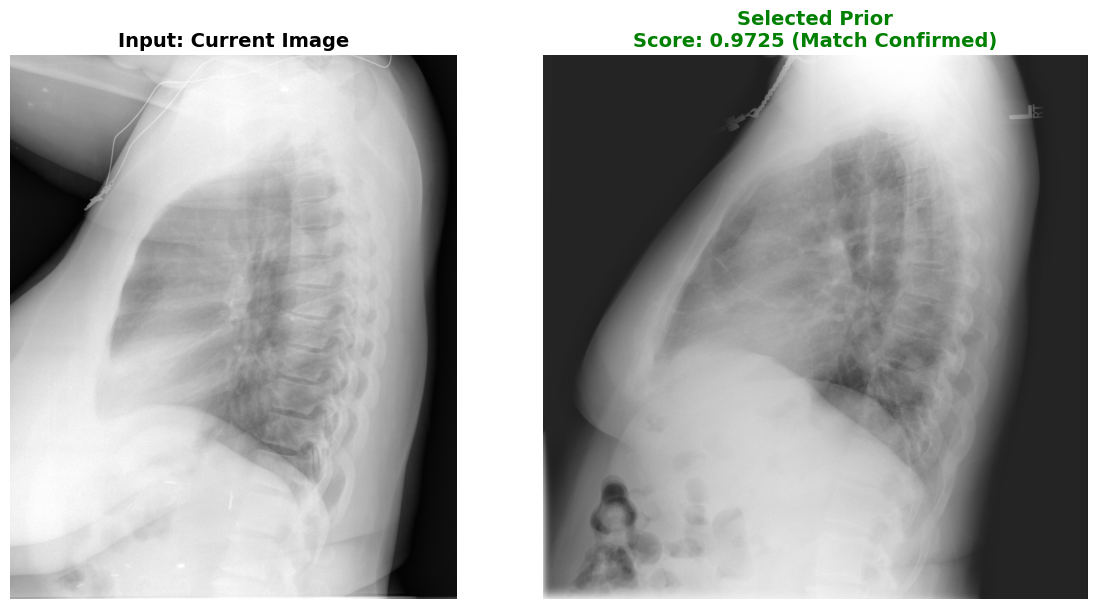

In [6]:
import matplotlib.pyplot as plt
from PIL import Image

def visualize_match(current_path, prior_path, score):
    """
    Displays the Current Image and the Selected Prior side-by-side.
    """
    # 1. Load the images from disk
    img_current = Image.open(current_path).convert("RGB")
    img_prior = Image.open(prior_path).convert("RGB")
    
    # 2. Create the plot layout (1 row, 2 columns)
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Left Side: Current Image
    axes[0].imshow(img_current, cmap='gray')
    axes[0].set_title("Input: Current Image", fontsize=14, fontweight='bold')
    axes[0].axis("off") # Hide ugly X/Y axis numbers
    
    # Right Side: Selected Prior
    axes[1].imshow(img_prior, cmap='gray')
    
    # Color-code the title based on the score
    if score > 0.85:
        status_color = "green"
        status_text = "Match Confirmed"
    else:
        status_color = "red"
        status_text = "Low Confidence"
        
    axes[1].set_title(f"Selected Prior\nScore: {score:.4f} ({status_text})", 
                      fontsize=14, fontweight='bold', color=status_color)
    axes[1].axis("off")
    
    plt.tight_layout()
    plt.show()

# --- RUN THE VISUALIZATION ---
print(f"Visualizing match for: {os.path.basename(current_image)}...")
visualize_match(current_image, best_image, score)

Agent 2 : The gatekeeper 

In [7]:
from PIL import Image

def agent_2_gatekeeper(current_path, prior_path, score):
    """
    Decides if the pair of images is good enough for clinical comparison.
    """
    print(f"\n🛡️ AGENT 2 (GATEKEEPER) ANALYZING...")
    print(f"   Input Score: {score:.4f}")

    # --- RULE 1: THE DUPLICATE CHECK ---
    # If the score is basically 1.0, we are comparing the image to itself.
    # This is a common error in automated systems.
    if score > 0.99:
        return {
            "status": "REJECTED",
            "reason": "❌ DUPLICATE: Images are identical. No changes to detect.",
            "images": None
        }

    # --- RULE 2: THE RELEVANCE CHECK ---
    # If the score is too low, the images are not comparable (e.g., Chest vs. Abdomen).
    # The PDF suggests a threshold of 0.70.
    if score < 0.70:
        return {
            "status": "REJECTED",
            "reason": "❌ MISMATCH: Prior image is too different (wrong view or body part).",
            "images": None
        }

    # --- RULE 3: THE GOLDILOCKS ZONE (PASS) ---
    print("   ✅ PASSED: Images are comparable and distinct.")

    # --- RULE 4: PREPARATION (RESIZE) ---
    # The PDF states MedGemma requires higher resolution (896x896).
    # We prepare the images now so Agent 3 doesn't have to do it later.
    try:
        img_curr = Image.open(current_path).convert("RGB").resize((896, 896))
        img_prior = Image.open(prior_path).convert("RGB").resize((896, 896))
        
        return {
            "status": "APPROVED",
            "reason": "✅ Ready for Differential Diagnosis.",
            "images": (img_curr, img_prior)
        }
    except Exception as e:
        return {
            "status": "ERROR",
            "reason": f"❌ File Error: {str(e)}",
            "images": None
        }

Verification (The Stress Test)

In [8]:
# --- RUNNING AGENT 2 VERIFICATION ---

# 1. REAL TEST (Using the result from Agent 1)
# 'best_image' and 'score' come from the previous step you just ran
print("--- TEST CASE 1: REAL DATA ---")
result_real = agent_2_gatekeeper(current_image, best_image, score)
print(f"Result: {result_real['reason']}")

# 2. FAKE TEST: DUPLICATE (Force a score of 0.995)
print("\n--- TEST CASE 2: SIMULATED DUPLICATE ---")
result_dup = agent_2_gatekeeper(current_image, best_image, 0.995)
print(f"Result: {result_dup['reason']}")

# 3. FAKE TEST: BAD MATCH (Force a score of 0.40)
print("\n--- TEST CASE 3: SIMULATED MISMATCH ---")
result_bad = agent_2_gatekeeper(current_image, best_image, 0.40)
print(f"Result: {result_bad['reason']}")

--- TEST CASE 1: REAL DATA ---

🛡️ AGENT 2 (GATEKEEPER) ANALYZING...
   Input Score: 0.9725
   ✅ PASSED: Images are comparable and distinct.
Result: ✅ Ready for Differential Diagnosis.

--- TEST CASE 2: SIMULATED DUPLICATE ---

🛡️ AGENT 2 (GATEKEEPER) ANALYZING...
   Input Score: 0.9950
Result: ❌ DUPLICATE: Images are identical. No changes to detect.

--- TEST CASE 3: SIMULATED MISMATCH ---

🛡️ AGENT 2 (GATEKEEPER) ANALYZING...
   Input Score: 0.4000
Result: ❌ MISMATCH: Prior image is too different (wrong view or body part).
